# Deep Neural Network for Image Classification: Application

You will use use the functions you'd implemented in the previous assignment to build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

In [129]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import gc
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
def load_data_helper(pixels, numElements, trainPercentage):
    train_x_orig, train_y, dev_x_orig, dev_y, test_x_orig, test_y, classes = load_data(pixels, numElements, trainPercentage)
    
    # Reshape the training and dev examples 
    train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
    dev_x_flatten = dev_x_orig.reshape(dev_x_orig.shape[0], -1).T
    test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

    # Standardize data to have feature values between 0 and 1.
    train_x = train_x_flatten/255.
    dev_x = dev_x_flatten/255.
    test_x = test_x_flatten/255.
    
    print ("Number of training examples: " + str(train_x_orig.shape[0]))
    print ("Number of dev examples: " + str(dev_x_orig.shape[0]))
    print ("Number of test examples: " + str(test_x_orig.shape[0]))
    print ("Each image is of size: (" + str(train_x_orig.shape[1]) + ", " + str(train_x_orig.shape[1]) + ", 3)")
    print ("train_x's shape: " + str(train_x.shape))
    print ("Dev_x's shape: " + str(dev_x.shape))
    print ("Test_x's shape: " + str(test_x.shape))
    print ("Test_y's shape: " + str(test_y.shape))
    print("classes: ", classes)
    print ("Train (normal): " + str(len(np.where(train_y[0] == 0,)[0])))
    print ("Train (pneumonia): " + str(len(np.where(train_y[0] == 1,)[0])))
    print ("Dev (normal): " + str(len(np.where(dev_y[0] == 0,)[0])))
    print ("Dev (pneumonia): " + str(len(np.where(dev_y[0] == 1,)[0])))
    print ("Test (normal): " + str(len(np.where(test_y[0] == 0,)[0])))
    print ("Test (pneumonia): " + str(len(np.where(test_y[0] == 1,)[0])))
    
    return train_x, train_y, dev_x, dev_y, test_x, test_y

In [144]:
train_x, train_y, dev_x, dev_y, test_x, test_y = load_data_helper(64,600,0.9)

Number of training examples: 540
Number of dev examples: 60
Number of test examples: 525
Each image is of size: (64, 64, 3)
train_x's shape: (12288, 540)
Dev_x's shape: (12288, 60)
Test_x's shape: (12288, 525)
Test_y's shape: (1, 525)
classes:  ['NORMAL' 'PNEUMONIA']
Train (normal): 142
Train (pneumonia): 398
Dev (normal): 14
Dev (pneumonia): 46
Test (normal): 151
Test (pneumonia): 374


The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 1. It's a PNEUMONIA picture.


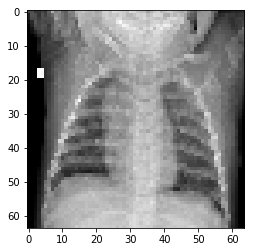

In [146]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]] +  " picture.")

In [145]:
### Hyper-Parameters ###
pixels = 64
numElements = 600
trainingPercentage = 0.6

train_x, train_y, dev_x, dev_y, test_x, test_y = load_data_helper(pixels, numElements, trainingPercentage)
layers_dims = [pixels*pixels*3, 20, 7, 5, 1] #  4-layer model
print("Entry layer: ", pixels*pixels*3)

Number of training examples: 360
Number of dev examples: 240
Number of test examples: 525
Each image is of size: (64, 64, 3)
train_x's shape: (12288, 360)
Dev_x's shape: (12288, 240)
Test_x's shape: (12288, 525)
Test_y's shape: (1, 525)
classes:  ['NORMAL' 'PNEUMONIA']
Train (normal): 107
Train (pneumonia): 253
Dev (normal): 67
Dev (pneumonia): 173
Test (normal): 159
Test (pneumonia): 366
Entry layer:  12288


In [80]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

# Cambio de Learning Rate (600 Elementos)
En esta sección se correran diversas pruebas sobre el hiperparametro de learning rate, mientras se mantiene estático el tamaño del dataset en 600 ejemplos

### Learning rate de 0.1

Cost after iteration 0: 0.623660
Cost after iteration 100: 0.594254
Cost after iteration 200: 0.590847
Cost after iteration 300: 0.590842
Cost after iteration 400: 0.590842
Cost after iteration 500: 0.590842
Cost after iteration 600: 0.590842
Cost after iteration 700: 0.590842
Cost after iteration 800: 0.590842
Cost after iteration 900: 0.590842
Cost after iteration 1000: 0.590842
Cost after iteration 1100: 0.590842
Cost after iteration 1200: 0.590842
Cost after iteration 1300: 0.590842
Cost after iteration 1400: 0.590842
Cost after iteration 1500: 0.590842
Cost after iteration 1600: 0.590842
Cost after iteration 1700: 0.590842
Cost after iteration 1800: 0.590842
Cost after iteration 1900: 0.590842
Cost after iteration 2000: 0.590842
Cost after iteration 2100: 0.590842
Cost after iteration 2200: 0.590842
Cost after iteration 2300: 0.590842
Cost after iteration 2400: 0.590842


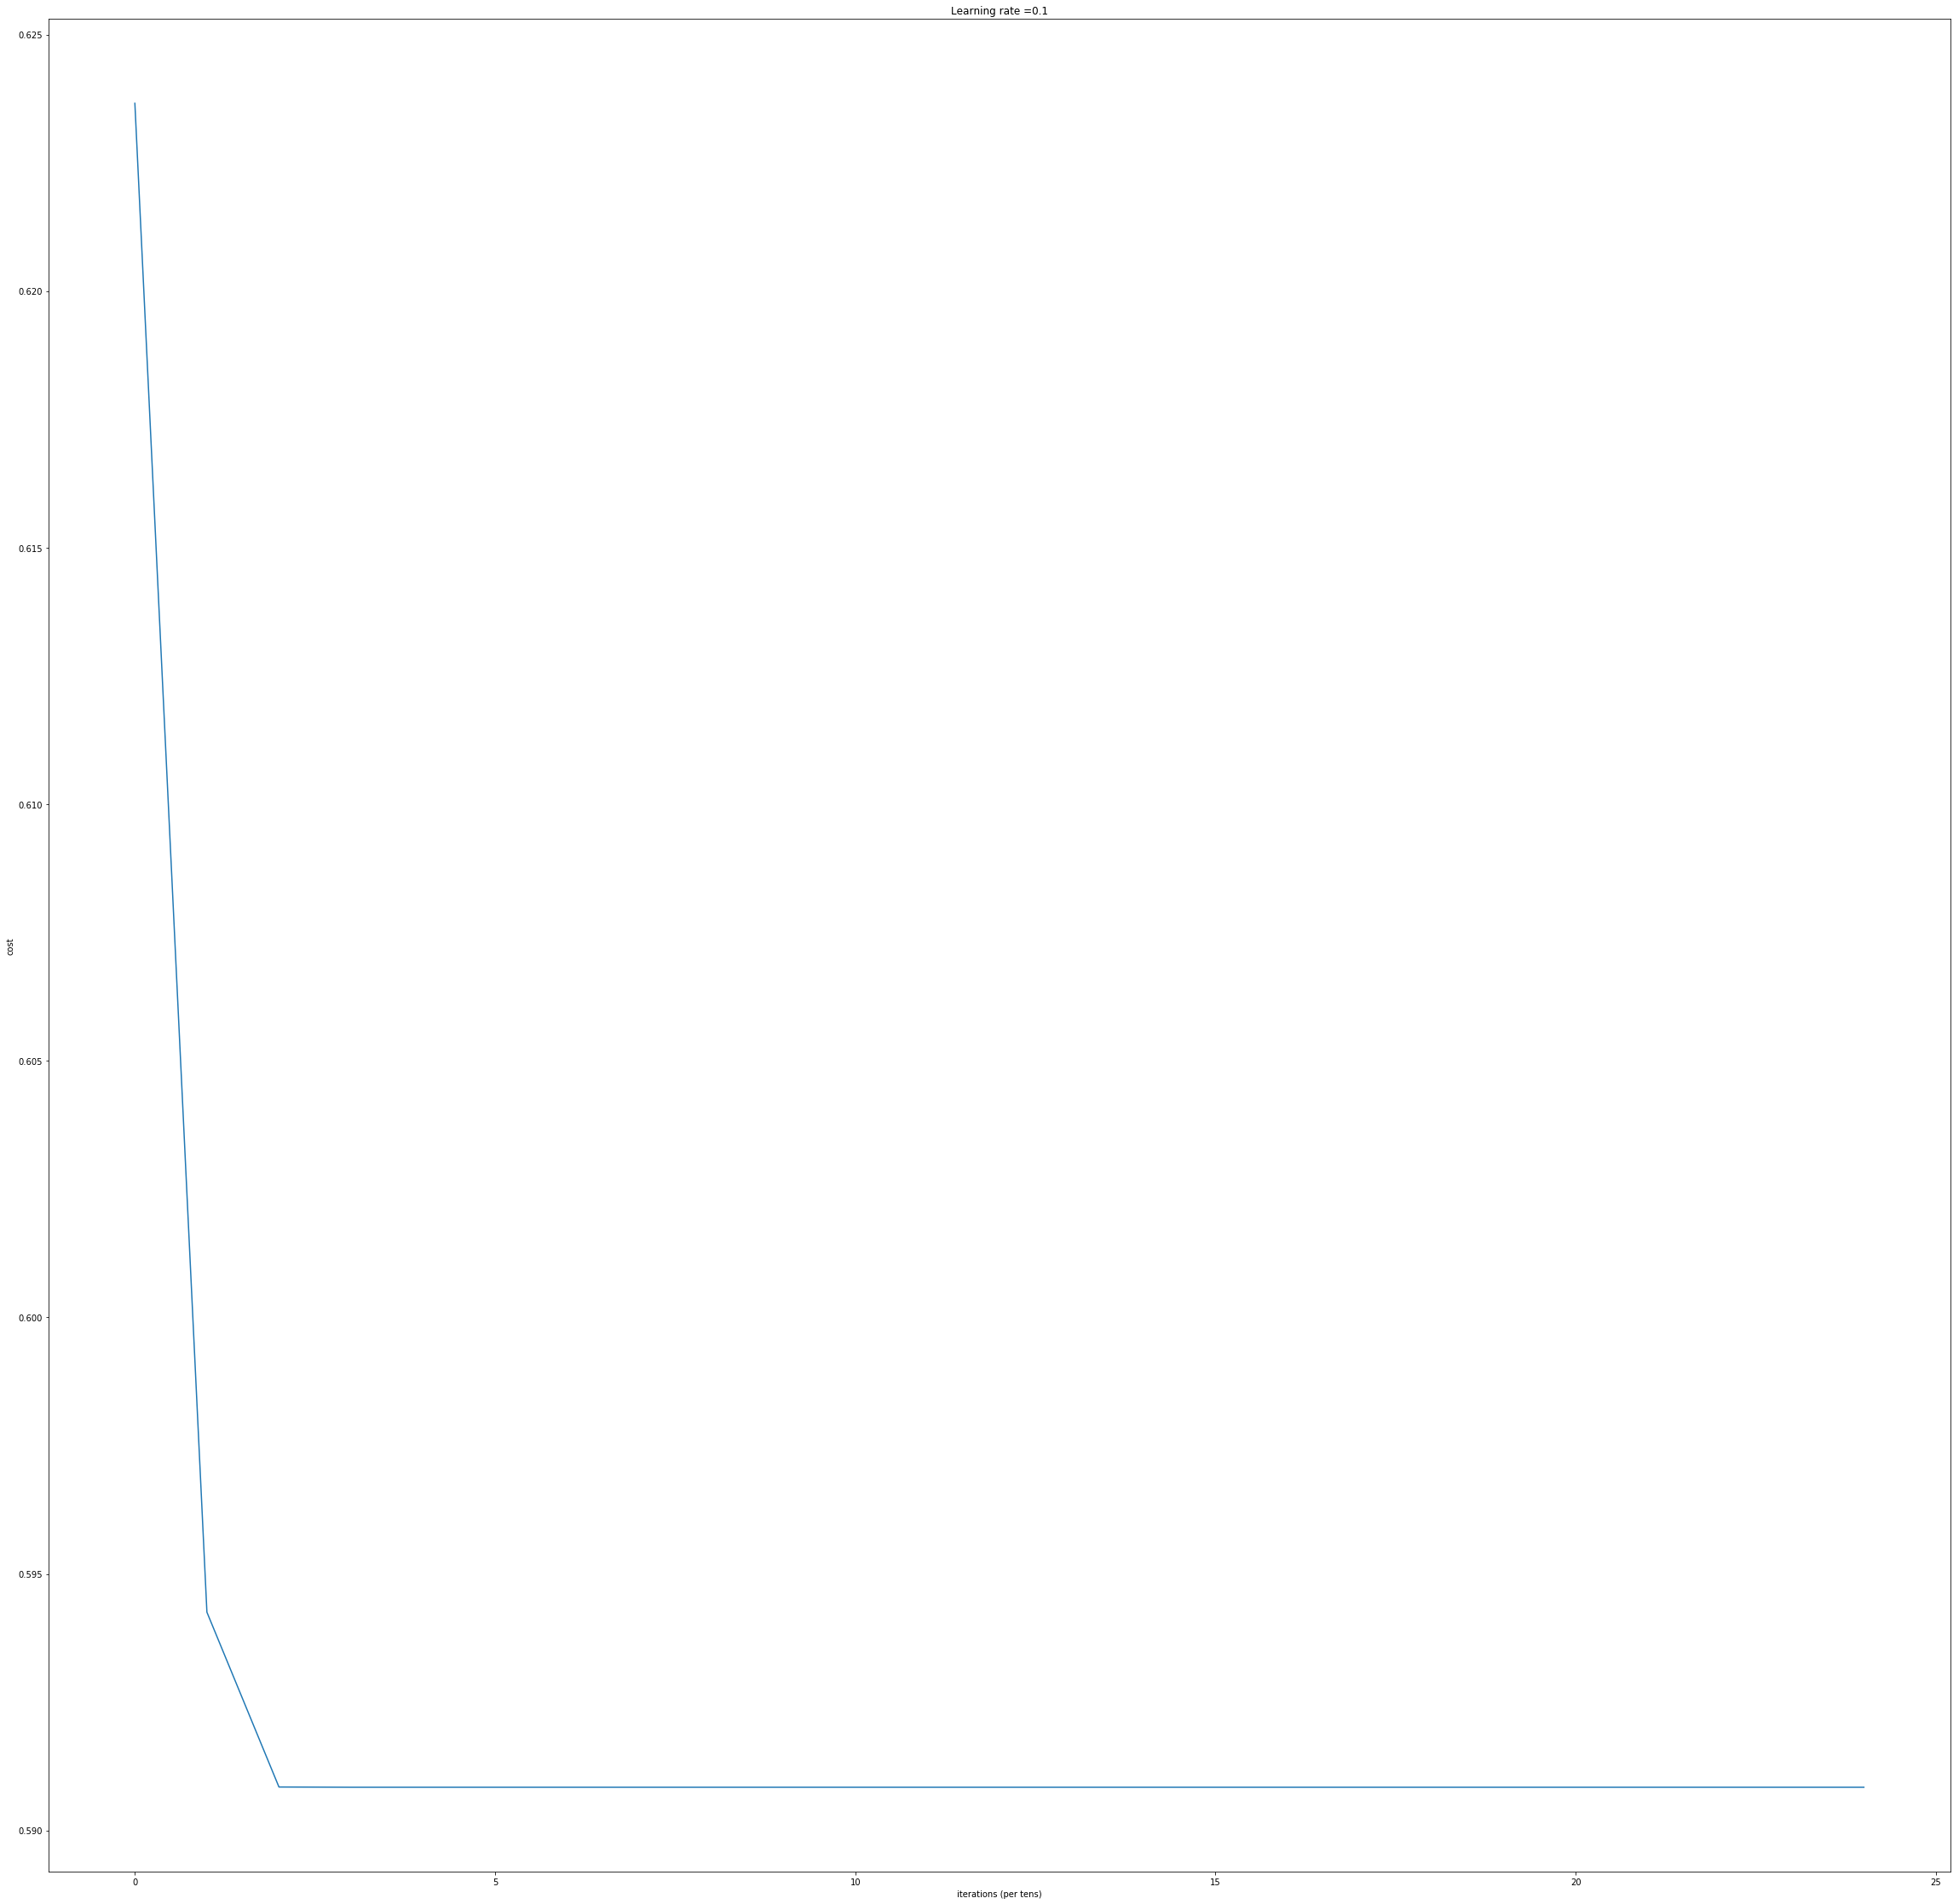

In [59]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.1, num_iterations = 2500, print_cost = True)

In [60]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.7222222222222223


In [61]:
pred_dev = predict(dev_x, dev_y, parameters)

Accuracy: 0.7041666666666666


### Learning rate de 0.01

Cost after iteration 0: 0.619365
Cost after iteration 100: 0.439514
Cost after iteration 200: 0.352901
Cost after iteration 300: 0.318275
Cost after iteration 400: 0.308025
Cost after iteration 500: 0.294207
Cost after iteration 600: 0.265003
Cost after iteration 700: 0.267003
Cost after iteration 800: 0.262686
Cost after iteration 900: 0.234521
Cost after iteration 1000: 0.246435
Cost after iteration 1100: 0.199290
Cost after iteration 1200: 0.189113
Cost after iteration 1300: 0.236808
Cost after iteration 1400: 0.198378
Cost after iteration 1500: 0.169291
Cost after iteration 1600: 0.164515
Cost after iteration 1700: 0.160513
Cost after iteration 1800: 0.170791
Cost after iteration 1900: 0.136723
Cost after iteration 2000: 0.134002
Cost after iteration 2100: 0.184028
Cost after iteration 2200: 0.218407
Cost after iteration 2300: 0.119109
Cost after iteration 2400: 0.110945


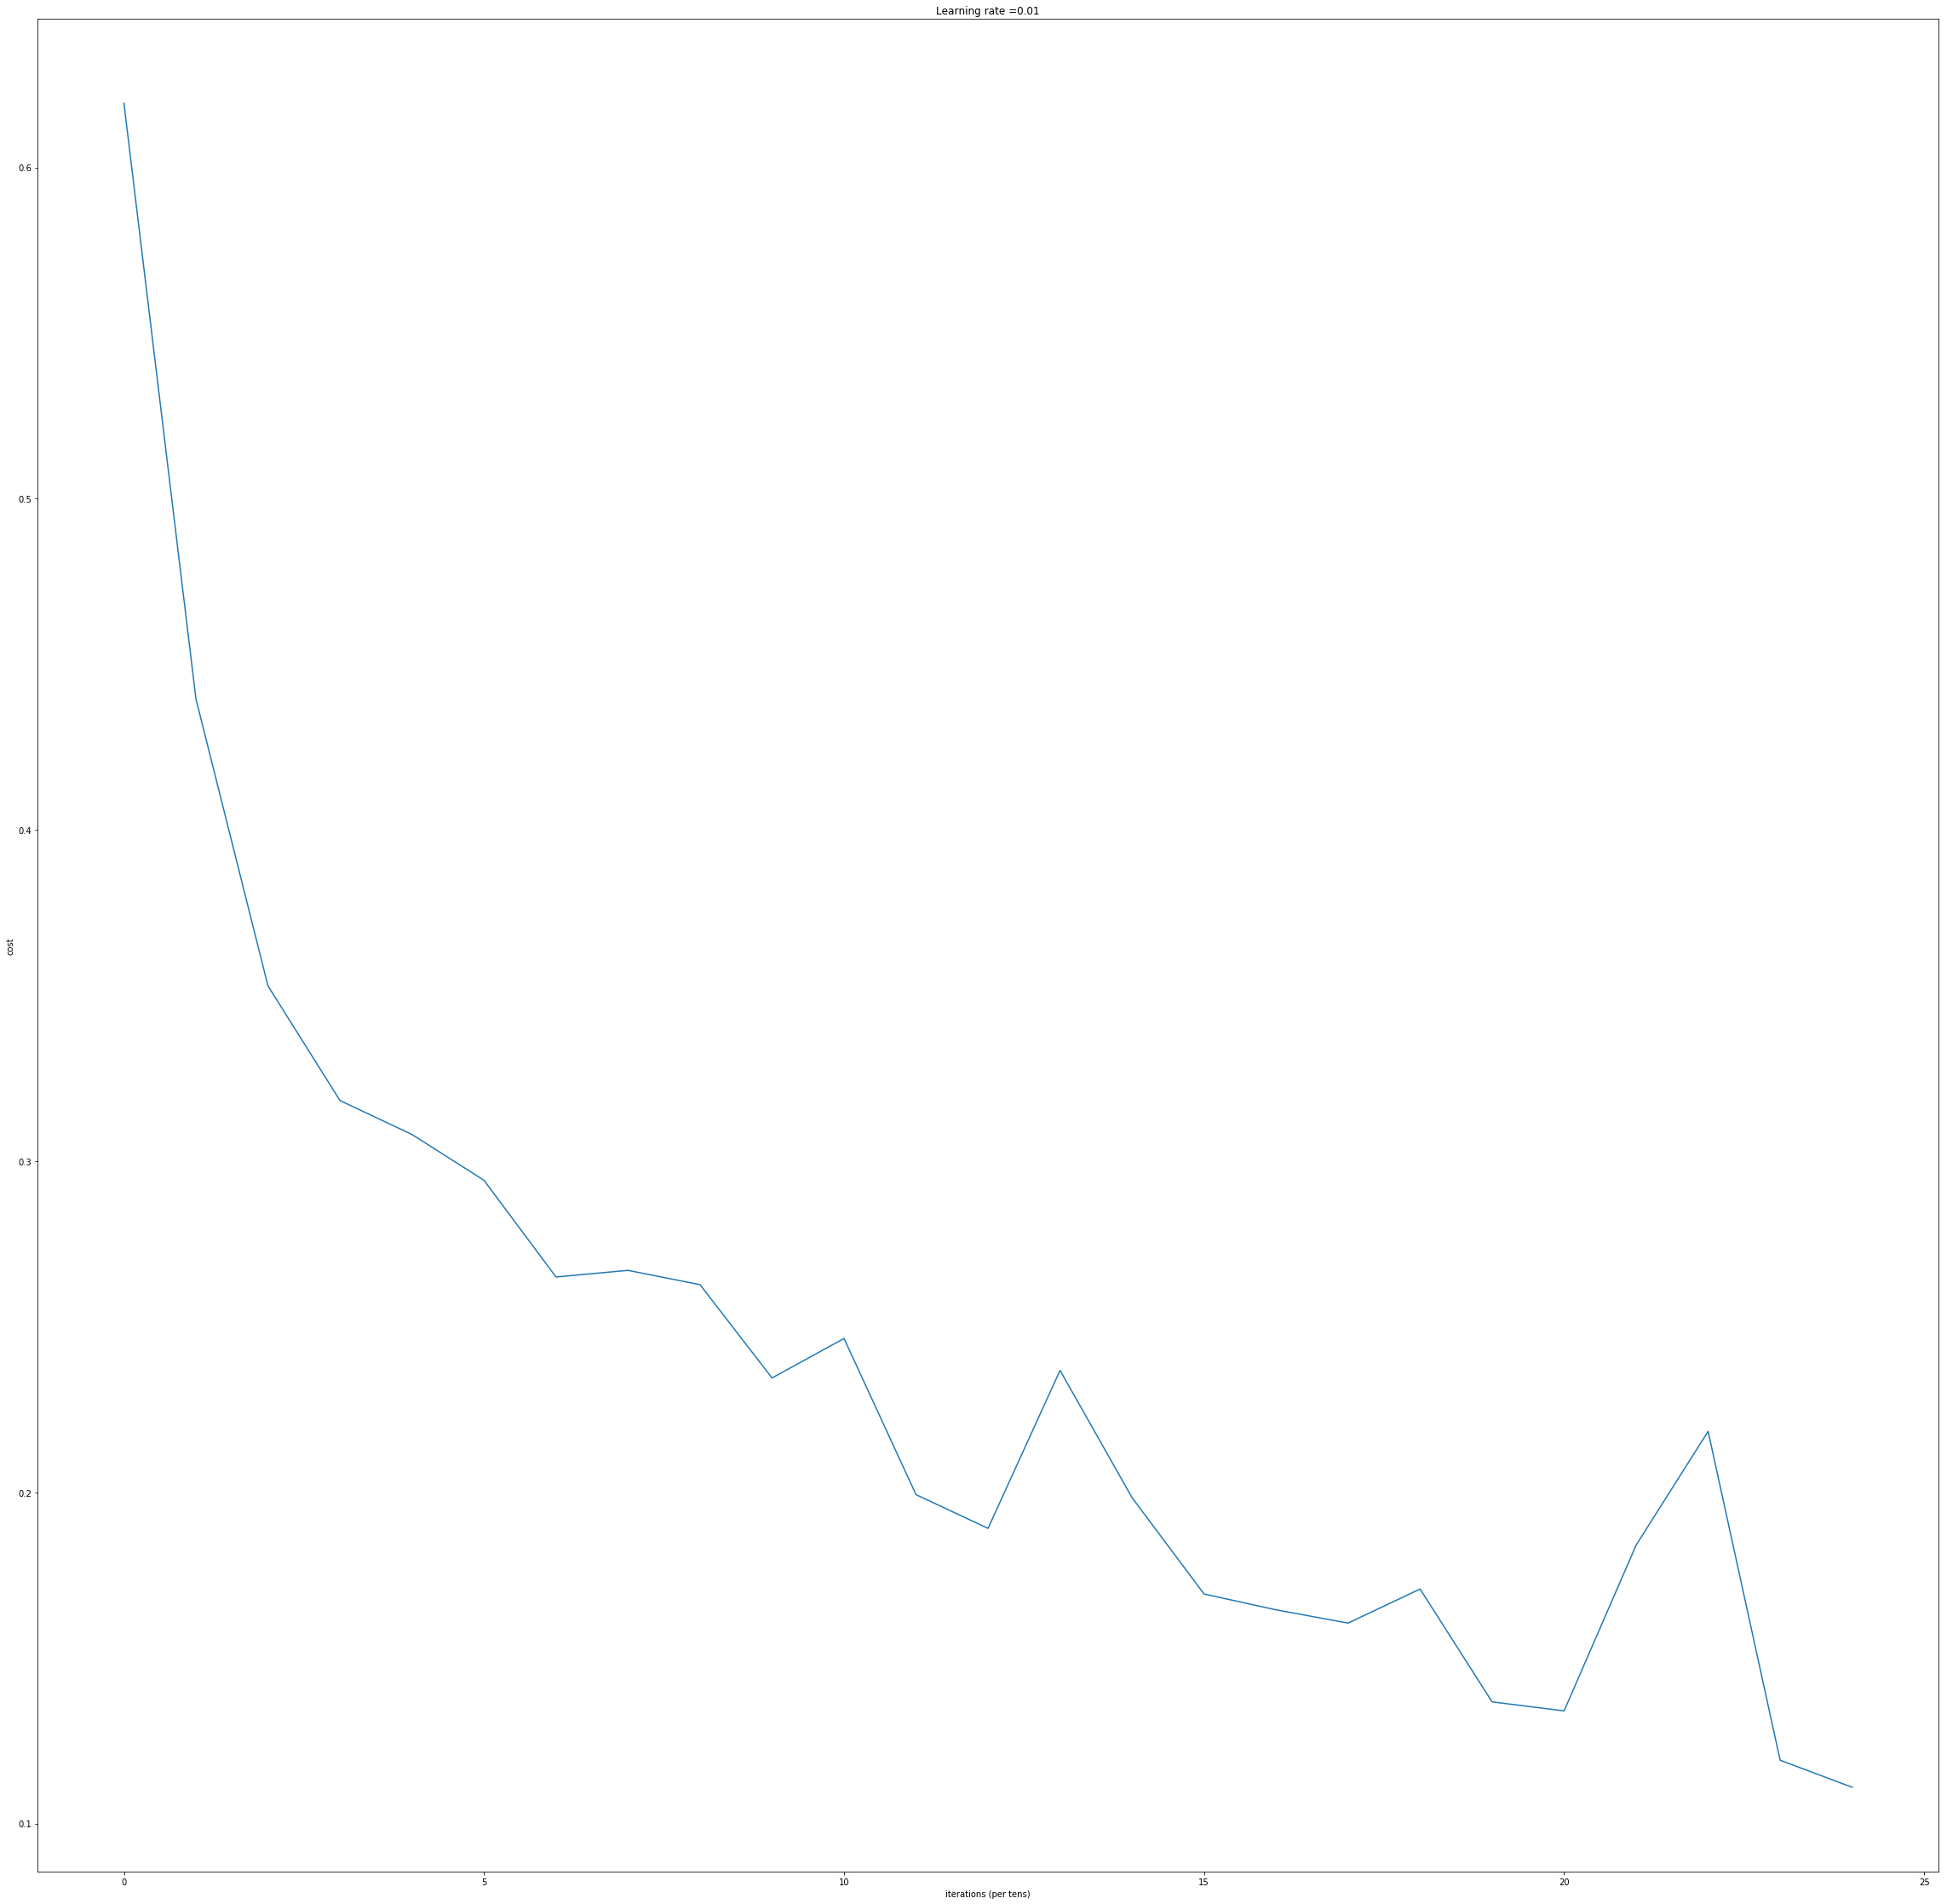

In [26]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.01, num_iterations = 2500, print_cost = True)

In [28]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9814814814814813


In [29]:
pred_dev = predict(dev_x, dev_y, parameters)

Accuracy: 0.9500000000000002


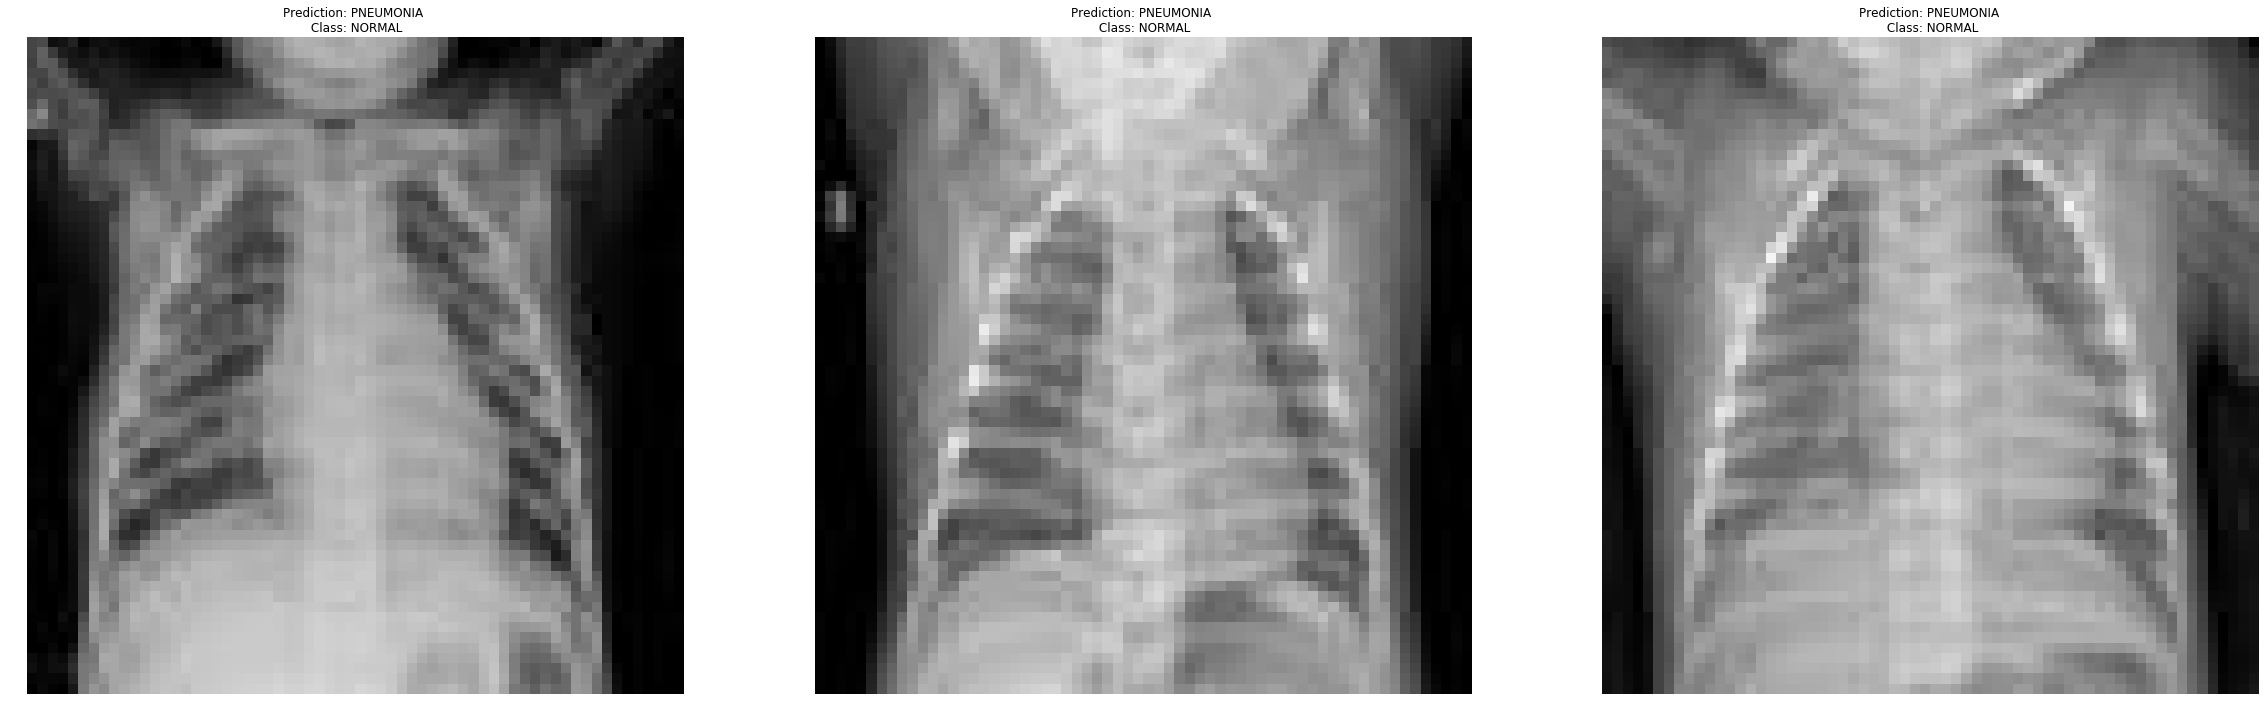

In [30]:
print_mislabeled_images(classes, dev_x, dev_y, pred_dev)

### Learning rate de 0.001

Cost after iteration 0: 0.619365
Cost after iteration 100: 0.510042
Cost after iteration 200: 0.459009
Cost after iteration 300: 0.426922
Cost after iteration 400: 0.404622
Cost after iteration 500: 0.388004
Cost after iteration 600: 0.374773
Cost after iteration 700: 0.363982
Cost after iteration 800: 0.354603
Cost after iteration 900: 0.346580
Cost after iteration 1000: 0.339715
Cost after iteration 1100: 0.333594
Cost after iteration 1200: 0.327919
Cost after iteration 1300: 0.322643
Cost after iteration 1400: 0.317801
Cost after iteration 1500: 0.313293
Cost after iteration 1600: 0.309062
Cost after iteration 1700: 0.305003
Cost after iteration 1800: 0.301071
Cost after iteration 1900: 0.297382
Cost after iteration 2000: 0.293861
Cost after iteration 2100: 0.290536
Cost after iteration 2200: 0.287417
Cost after iteration 2300: 0.284341
Cost after iteration 2400: 0.281338


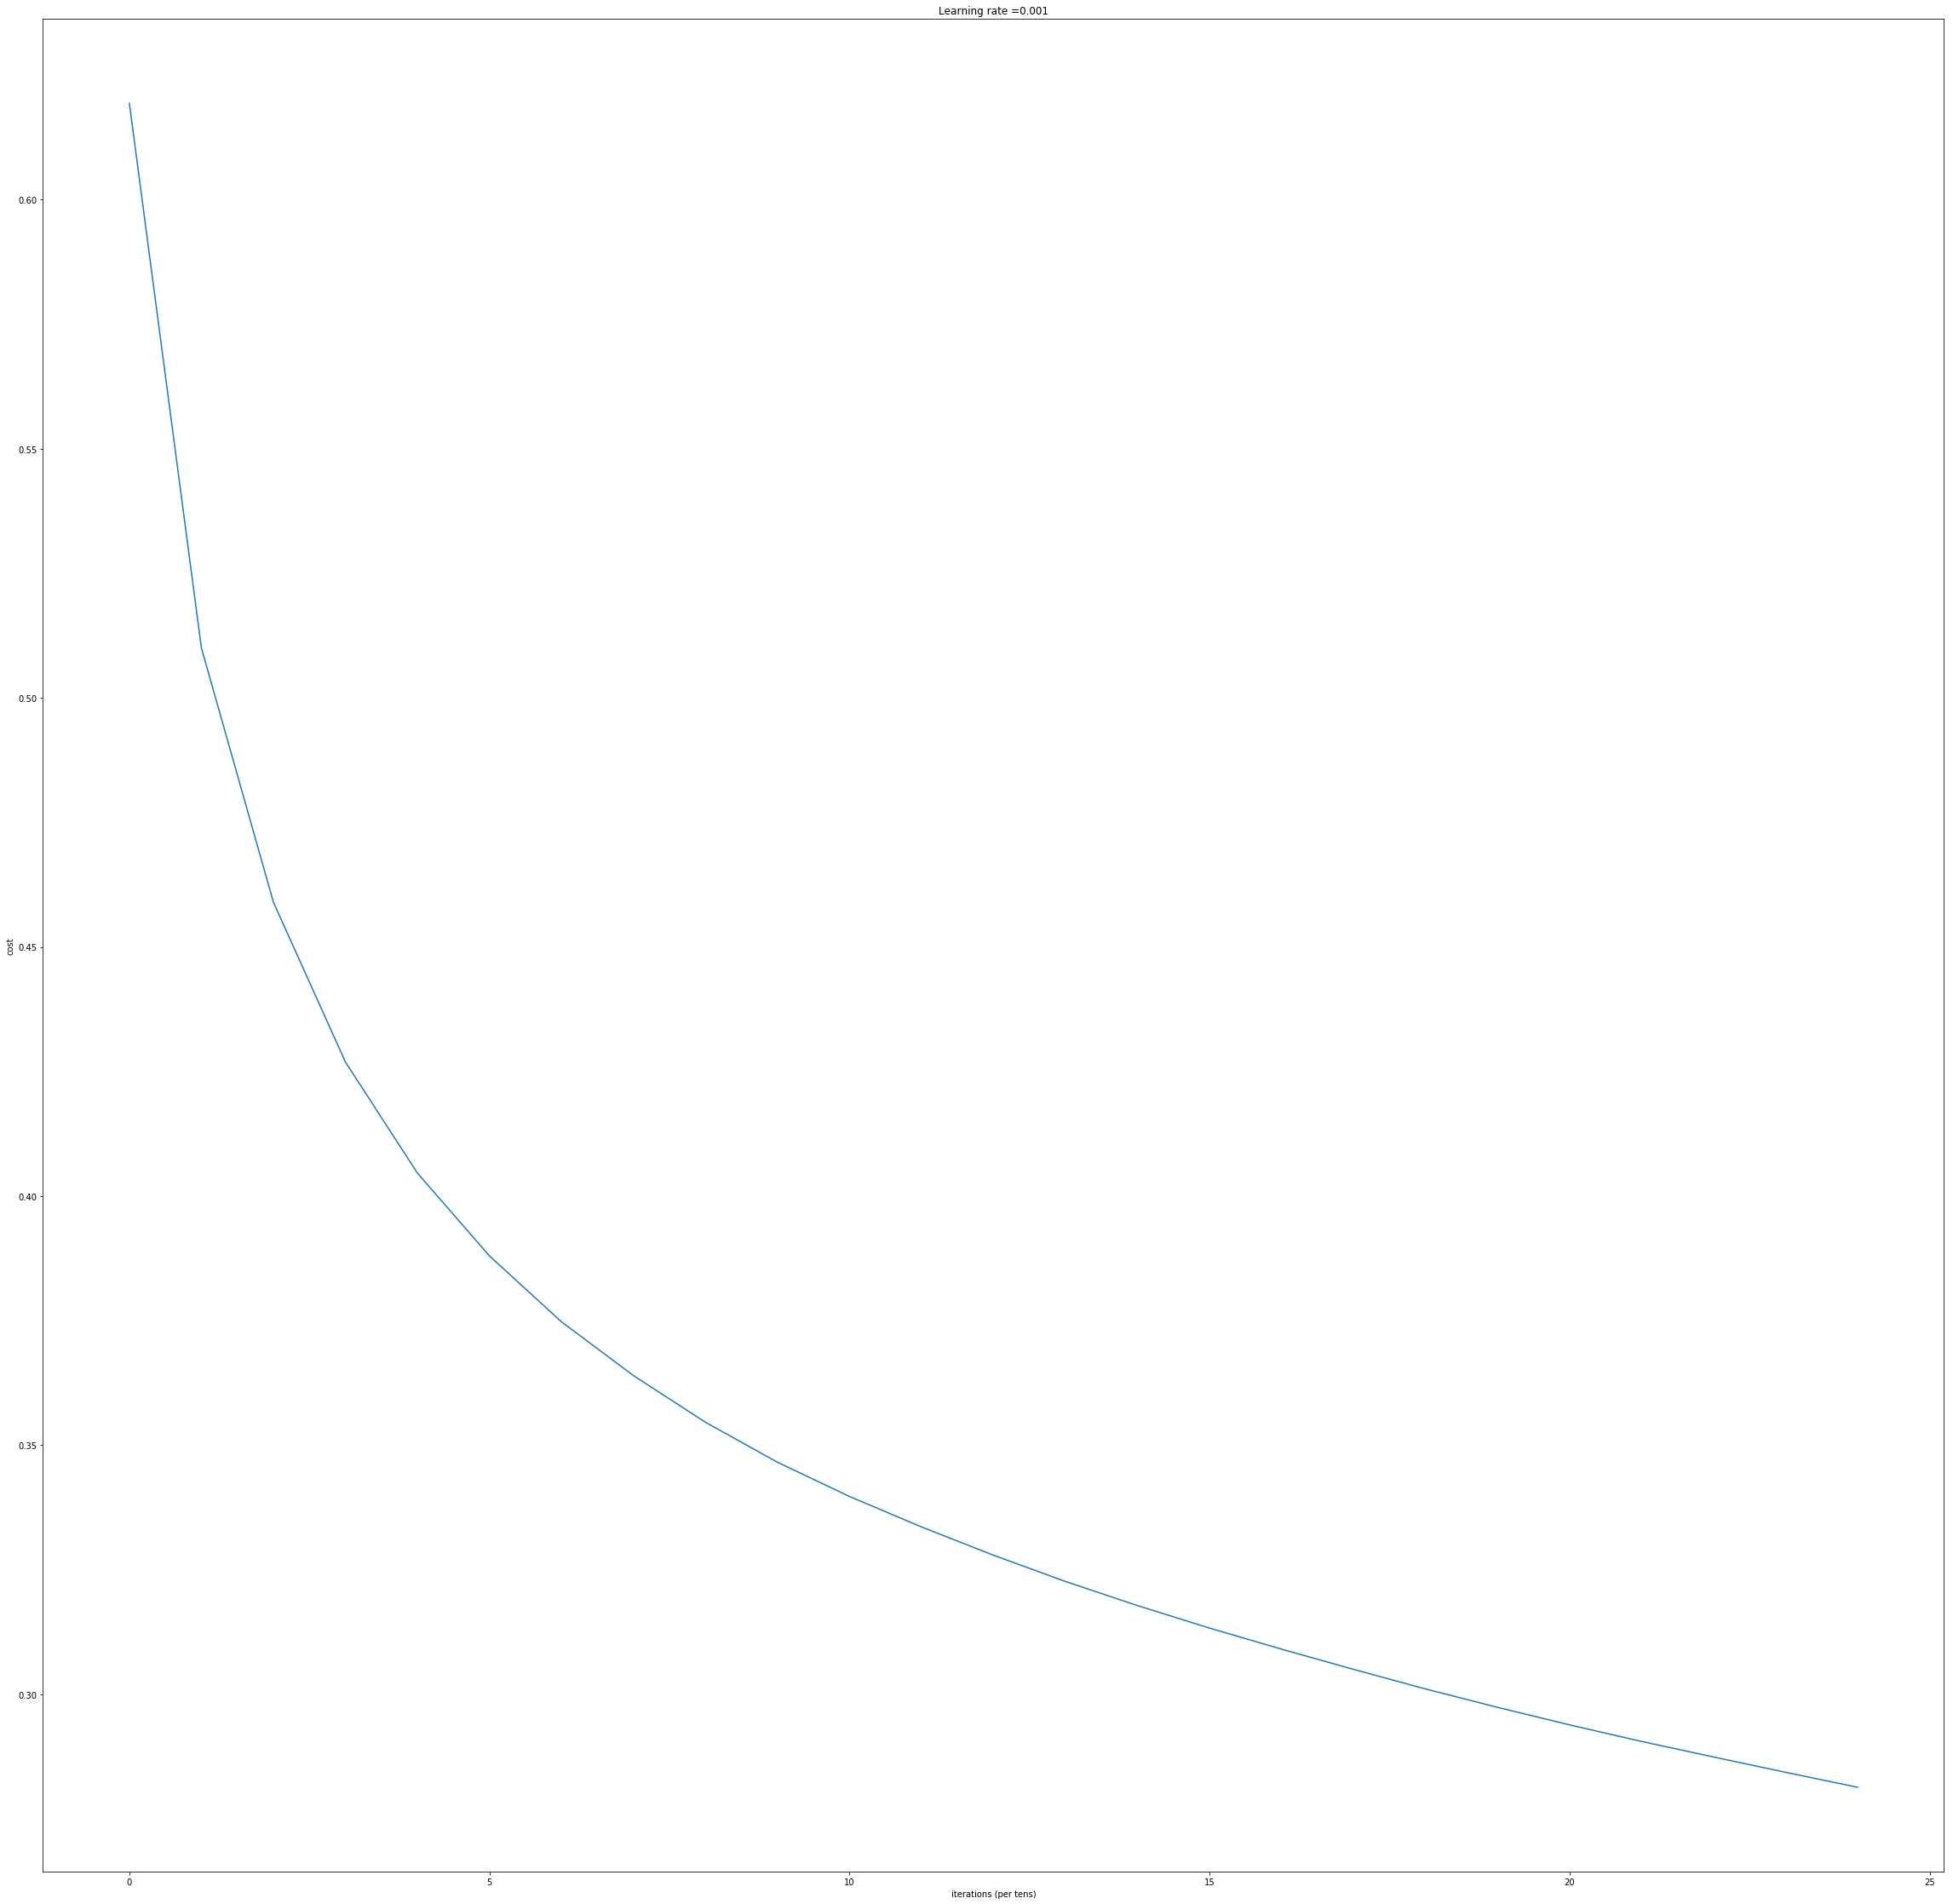

In [31]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.001, num_iterations = 2500, print_cost = True)

In [32]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9277777777777776


In [33]:
pred_dev = predict(dev_x, dev_y, parameters)

Accuracy: 0.9000000000000001


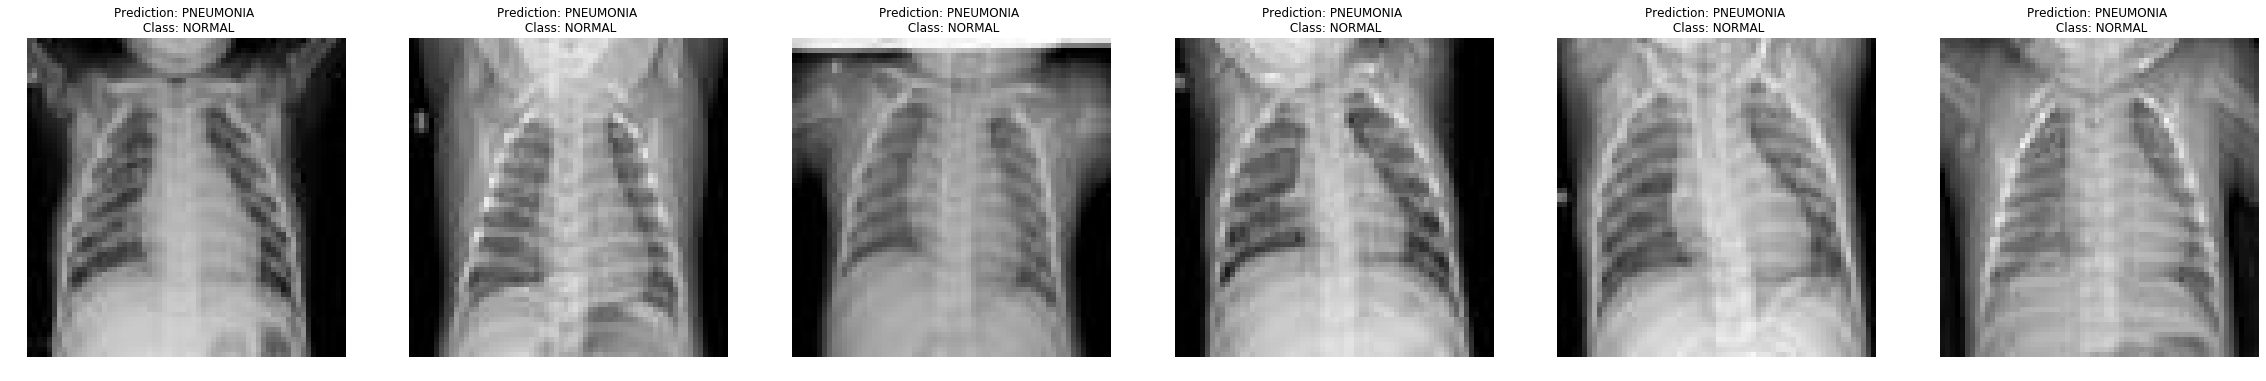

In [34]:
print_mislabeled_images(classes, dev_x, dev_y, pred_dev)

### Learning rate de 0.005

Cost after iteration 0: 0.623660
Cost after iteration 100: 0.386226
Cost after iteration 200: 0.315126
Cost after iteration 300: 0.285321
Cost after iteration 400: 0.264253
Cost after iteration 500: 0.241230
Cost after iteration 600: 0.230334
Cost after iteration 700: 0.214070
Cost after iteration 800: 0.202125
Cost after iteration 900: 0.193678
Cost after iteration 1000: 0.177612
Cost after iteration 1100: 0.191132
Cost after iteration 1200: 0.160069
Cost after iteration 1300: 0.152977
Cost after iteration 1400: 0.159987
Cost after iteration 1500: 0.139533
Cost after iteration 1600: 0.139066
Cost after iteration 1700: 0.134879
Cost after iteration 1800: 0.132540
Cost after iteration 1900: 0.119954
Cost after iteration 2000: 0.114814
Cost after iteration 2100: 0.112637
Cost after iteration 2200: 0.108465
Cost after iteration 2300: 0.104177
Cost after iteration 2400: 0.101456


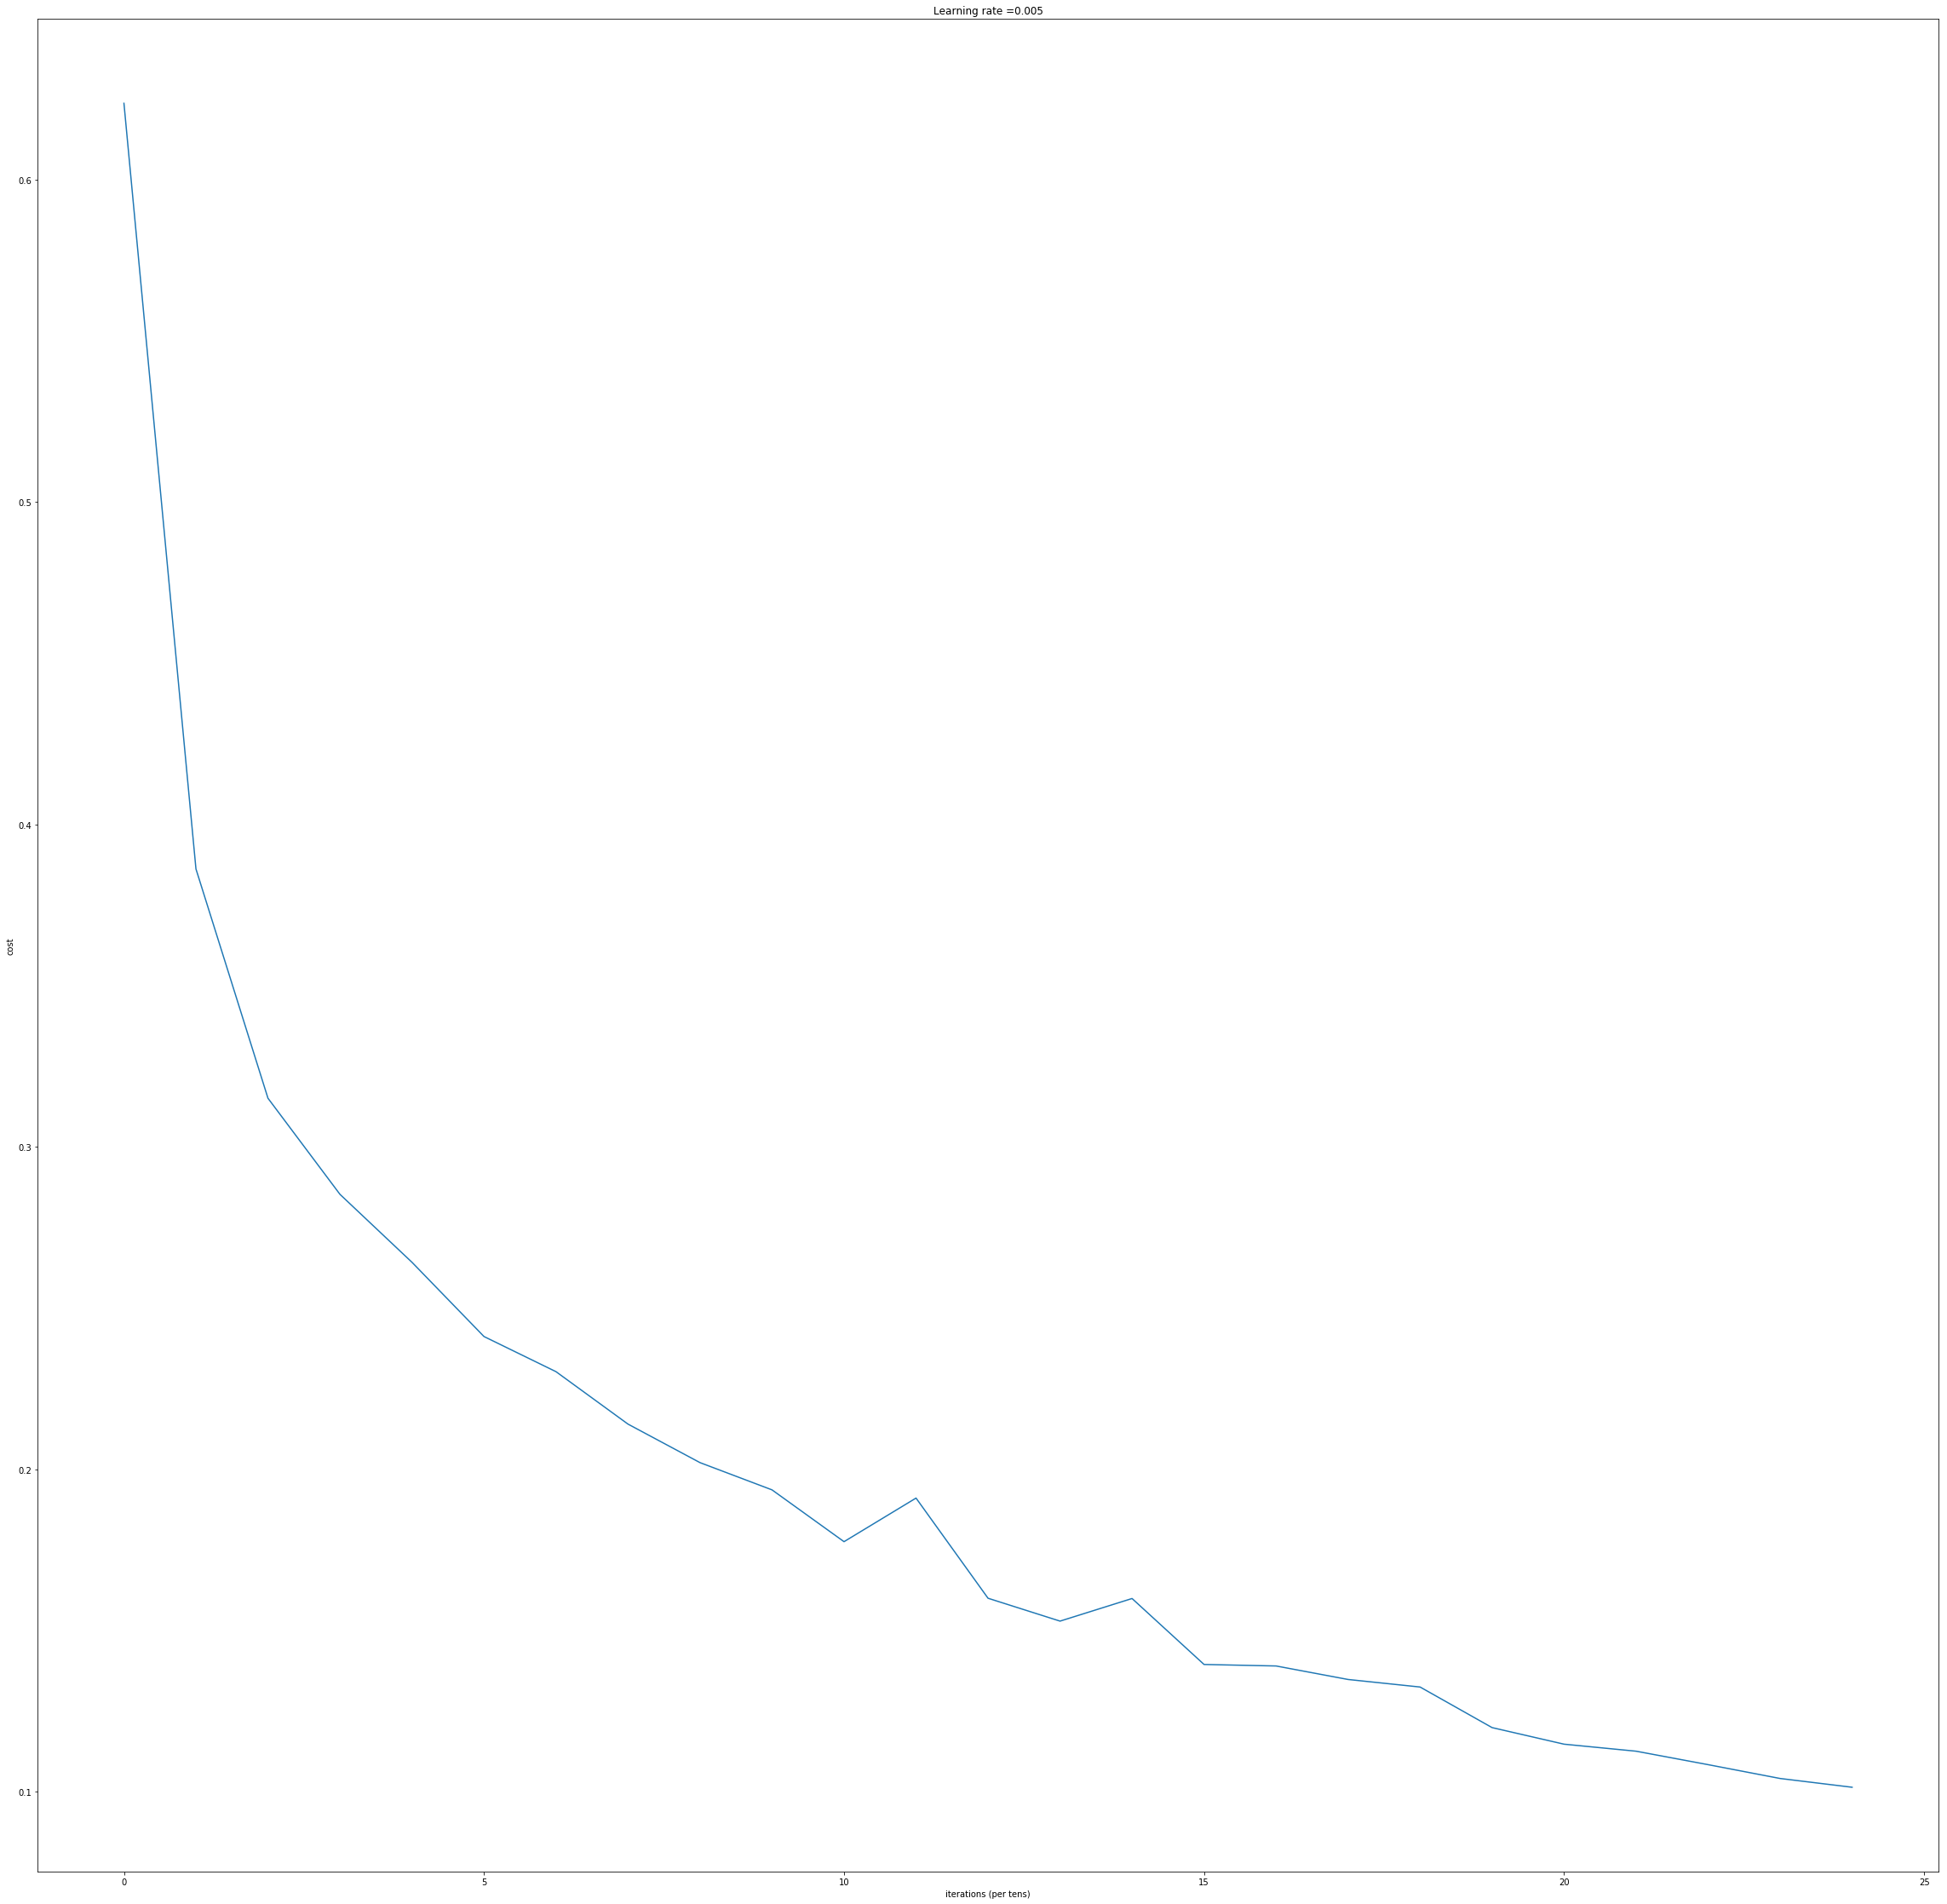

In [55]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.005, num_iterations = 2500, print_cost = True)

In [56]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9944444444444445


In [57]:
pred_dev = predict(dev_x, dev_y, parameters)

Accuracy: 0.9166666666666665


### Nota:
Se acepta el learning rate de 0.005.
Con estos datos, observamos que el aprendizaje del train set es perfecto, pero el accuracy no mejora.
Esto se debe a que los datos del training set no representan correctamente el dataset.
#### Para solucionar esto, aumentaremos el numero de datos en el training set

## Cambio de datos

### Configuracion
#### Numero de elementos: 1500 (70%/30%)

In [147]:
### Hyper-Parameters ###
pixels = 64
numElements = 1800
trainingPercentage = 0.75

train_x, train_y, dev_x, dev_y, test_x, test_y = load_data_helper(pixels, numElements, trainingPercentage)
layers_dims = [pixels*pixels*3, 20, 7, 5, 1] #  4-layer model
print("Entry layer: ", pixels*pixels*3)

Number of training examples: 1350
Number of dev examples: 450
Number of test examples: 405
Each image is of size: (64, 64, 3)
train_x's shape: (12288, 1350)
Dev_x's shape: (12288, 450)
Test_x's shape: (12288, 405)
Test_y's shape: (1, 405)
classes:  ['NORMAL' 'PNEUMONIA']
Train (normal): 388
Train (pneumonia): 962
Dev (normal): 118
Dev (pneumonia): 332
Test (normal): 151
Test (pneumonia): 254
Entry layer:  12288


Cost after iteration 0: 0.618120
Cost after iteration 100: 0.401228
Cost after iteration 200: 0.340690
Cost after iteration 300: 0.317650
Cost after iteration 400: 0.297722
Cost after iteration 500: 0.281917
Cost after iteration 600: 0.268153
Cost after iteration 700: 0.269680
Cost after iteration 800: 0.244907
Cost after iteration 900: 0.236498
Cost after iteration 1000: 0.243906
Cost after iteration 1100: 0.245036
Cost after iteration 1200: 0.241060
Cost after iteration 1300: 0.218539
Cost after iteration 1400: 0.215792
Cost after iteration 1500: 0.208494
Cost after iteration 1600: 0.223324
Cost after iteration 1700: 0.216341
Cost after iteration 1800: 0.216559
Cost after iteration 1900: 0.214362
Cost after iteration 2000: 0.199815
Cost after iteration 2100: 0.182632
Cost after iteration 2200: 0.173194
Cost after iteration 2300: 0.163177
Cost after iteration 2400: 0.180203


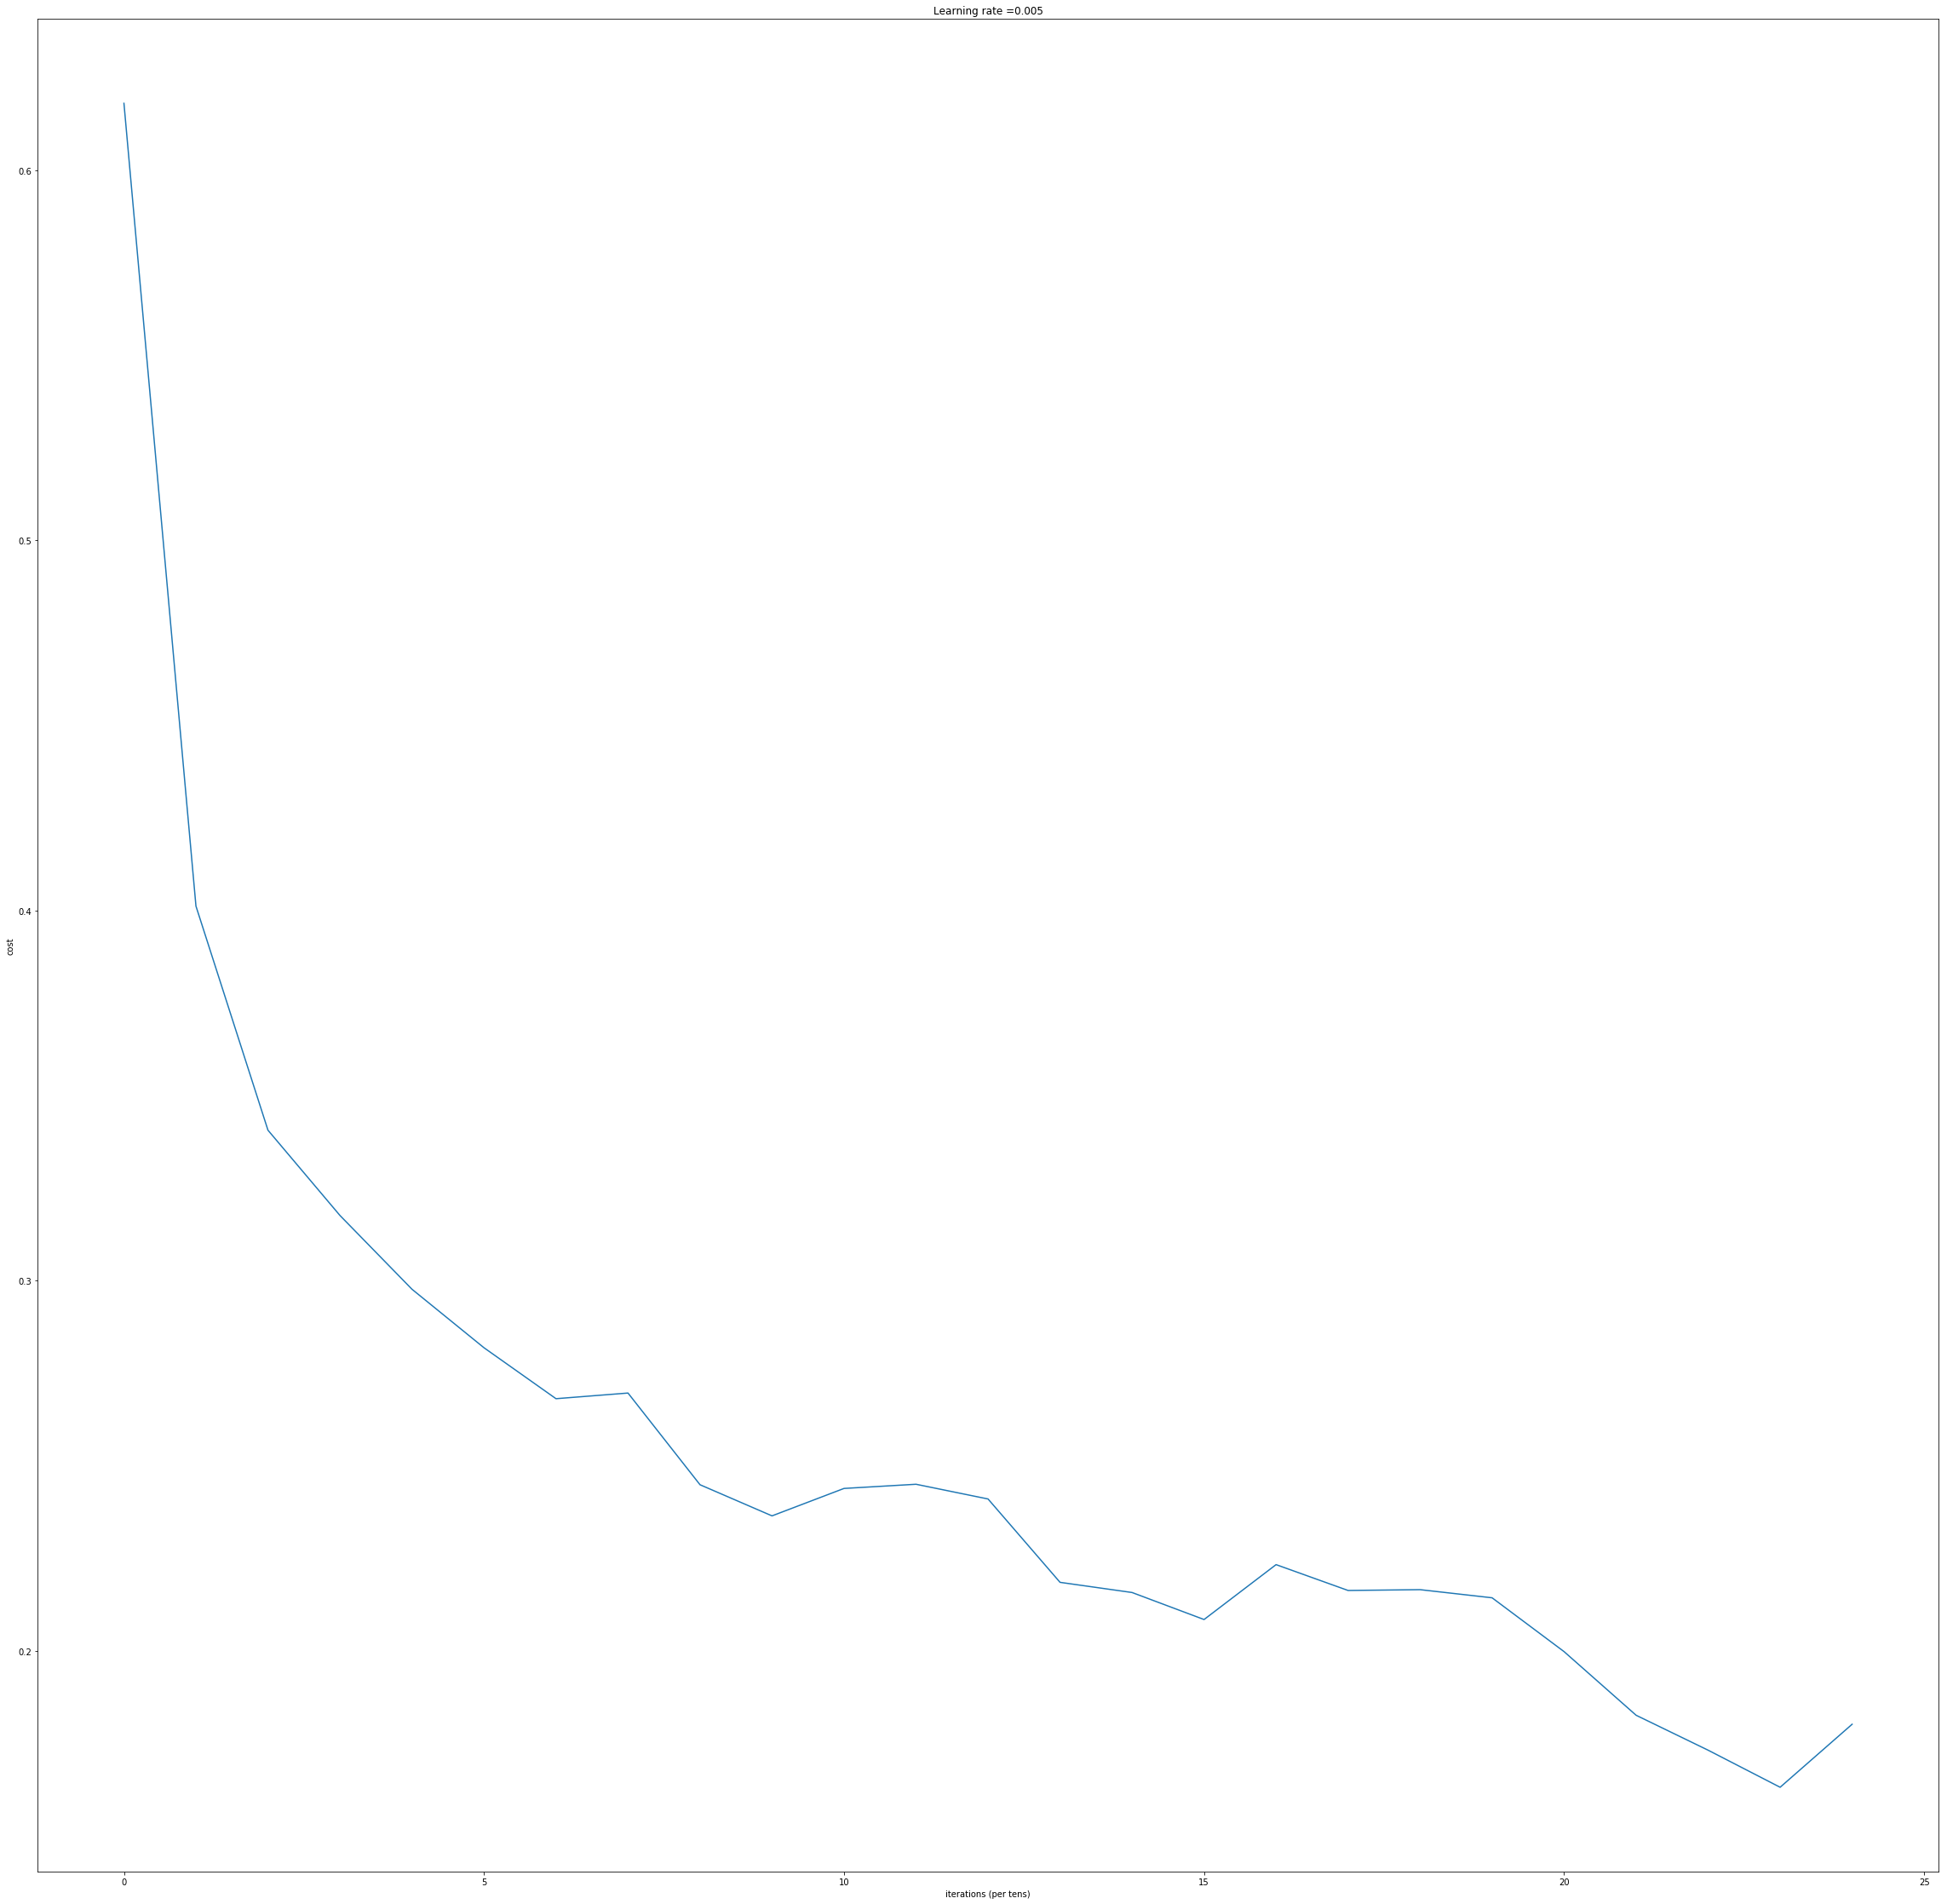

In [69]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.005, num_iterations = 2500, print_cost = True)

In [70]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9590476190476194


In [71]:
pred_dev = predict(dev_x, dev_y, parameters)

Accuracy: 0.92


### Nota: 
Vemos que el aprendizaje del training puede mejorar como hemos visto antes.
Pero el resultado del aprendizaje en el dev set se acerca mas al del training.
Esto significa que nuestros datos representan mejor el problema, pero es necesario modificar un poco el modelo para disminuir el bias, esperando que disminuya el variance a la par.
#### Para esto aumentaremos el numero de iteraciones

## Cambio de Iteraciones

### 5000 Iteraciones (learning rate 0.01)

Cost after iteration 0: 0.618120
Cost after iteration 100: 0.401228
Cost after iteration 200: 0.340690
Cost after iteration 300: 0.317650
Cost after iteration 400: 0.297722
Cost after iteration 500: 0.281917
Cost after iteration 600: 0.268153
Cost after iteration 700: 0.269680
Cost after iteration 800: 0.244907
Cost after iteration 900: 0.236498
Cost after iteration 1000: 0.243906
Cost after iteration 1100: 0.245036
Cost after iteration 1200: 0.241060
Cost after iteration 1300: 0.218539
Cost after iteration 1400: 0.215792
Cost after iteration 1500: 0.208494
Cost after iteration 1600: 0.223324
Cost after iteration 1700: 0.216341
Cost after iteration 1800: 0.216559
Cost after iteration 1900: 0.214362
Cost after iteration 2000: 0.199815
Cost after iteration 2100: 0.182632
Cost after iteration 2200: 0.173194
Cost after iteration 2300: 0.163177
Cost after iteration 2400: 0.180203
Cost after iteration 2500: 0.178139
Cost after iteration 2600: 0.174548
Cost after iteration 2700: 0.172808
Cost

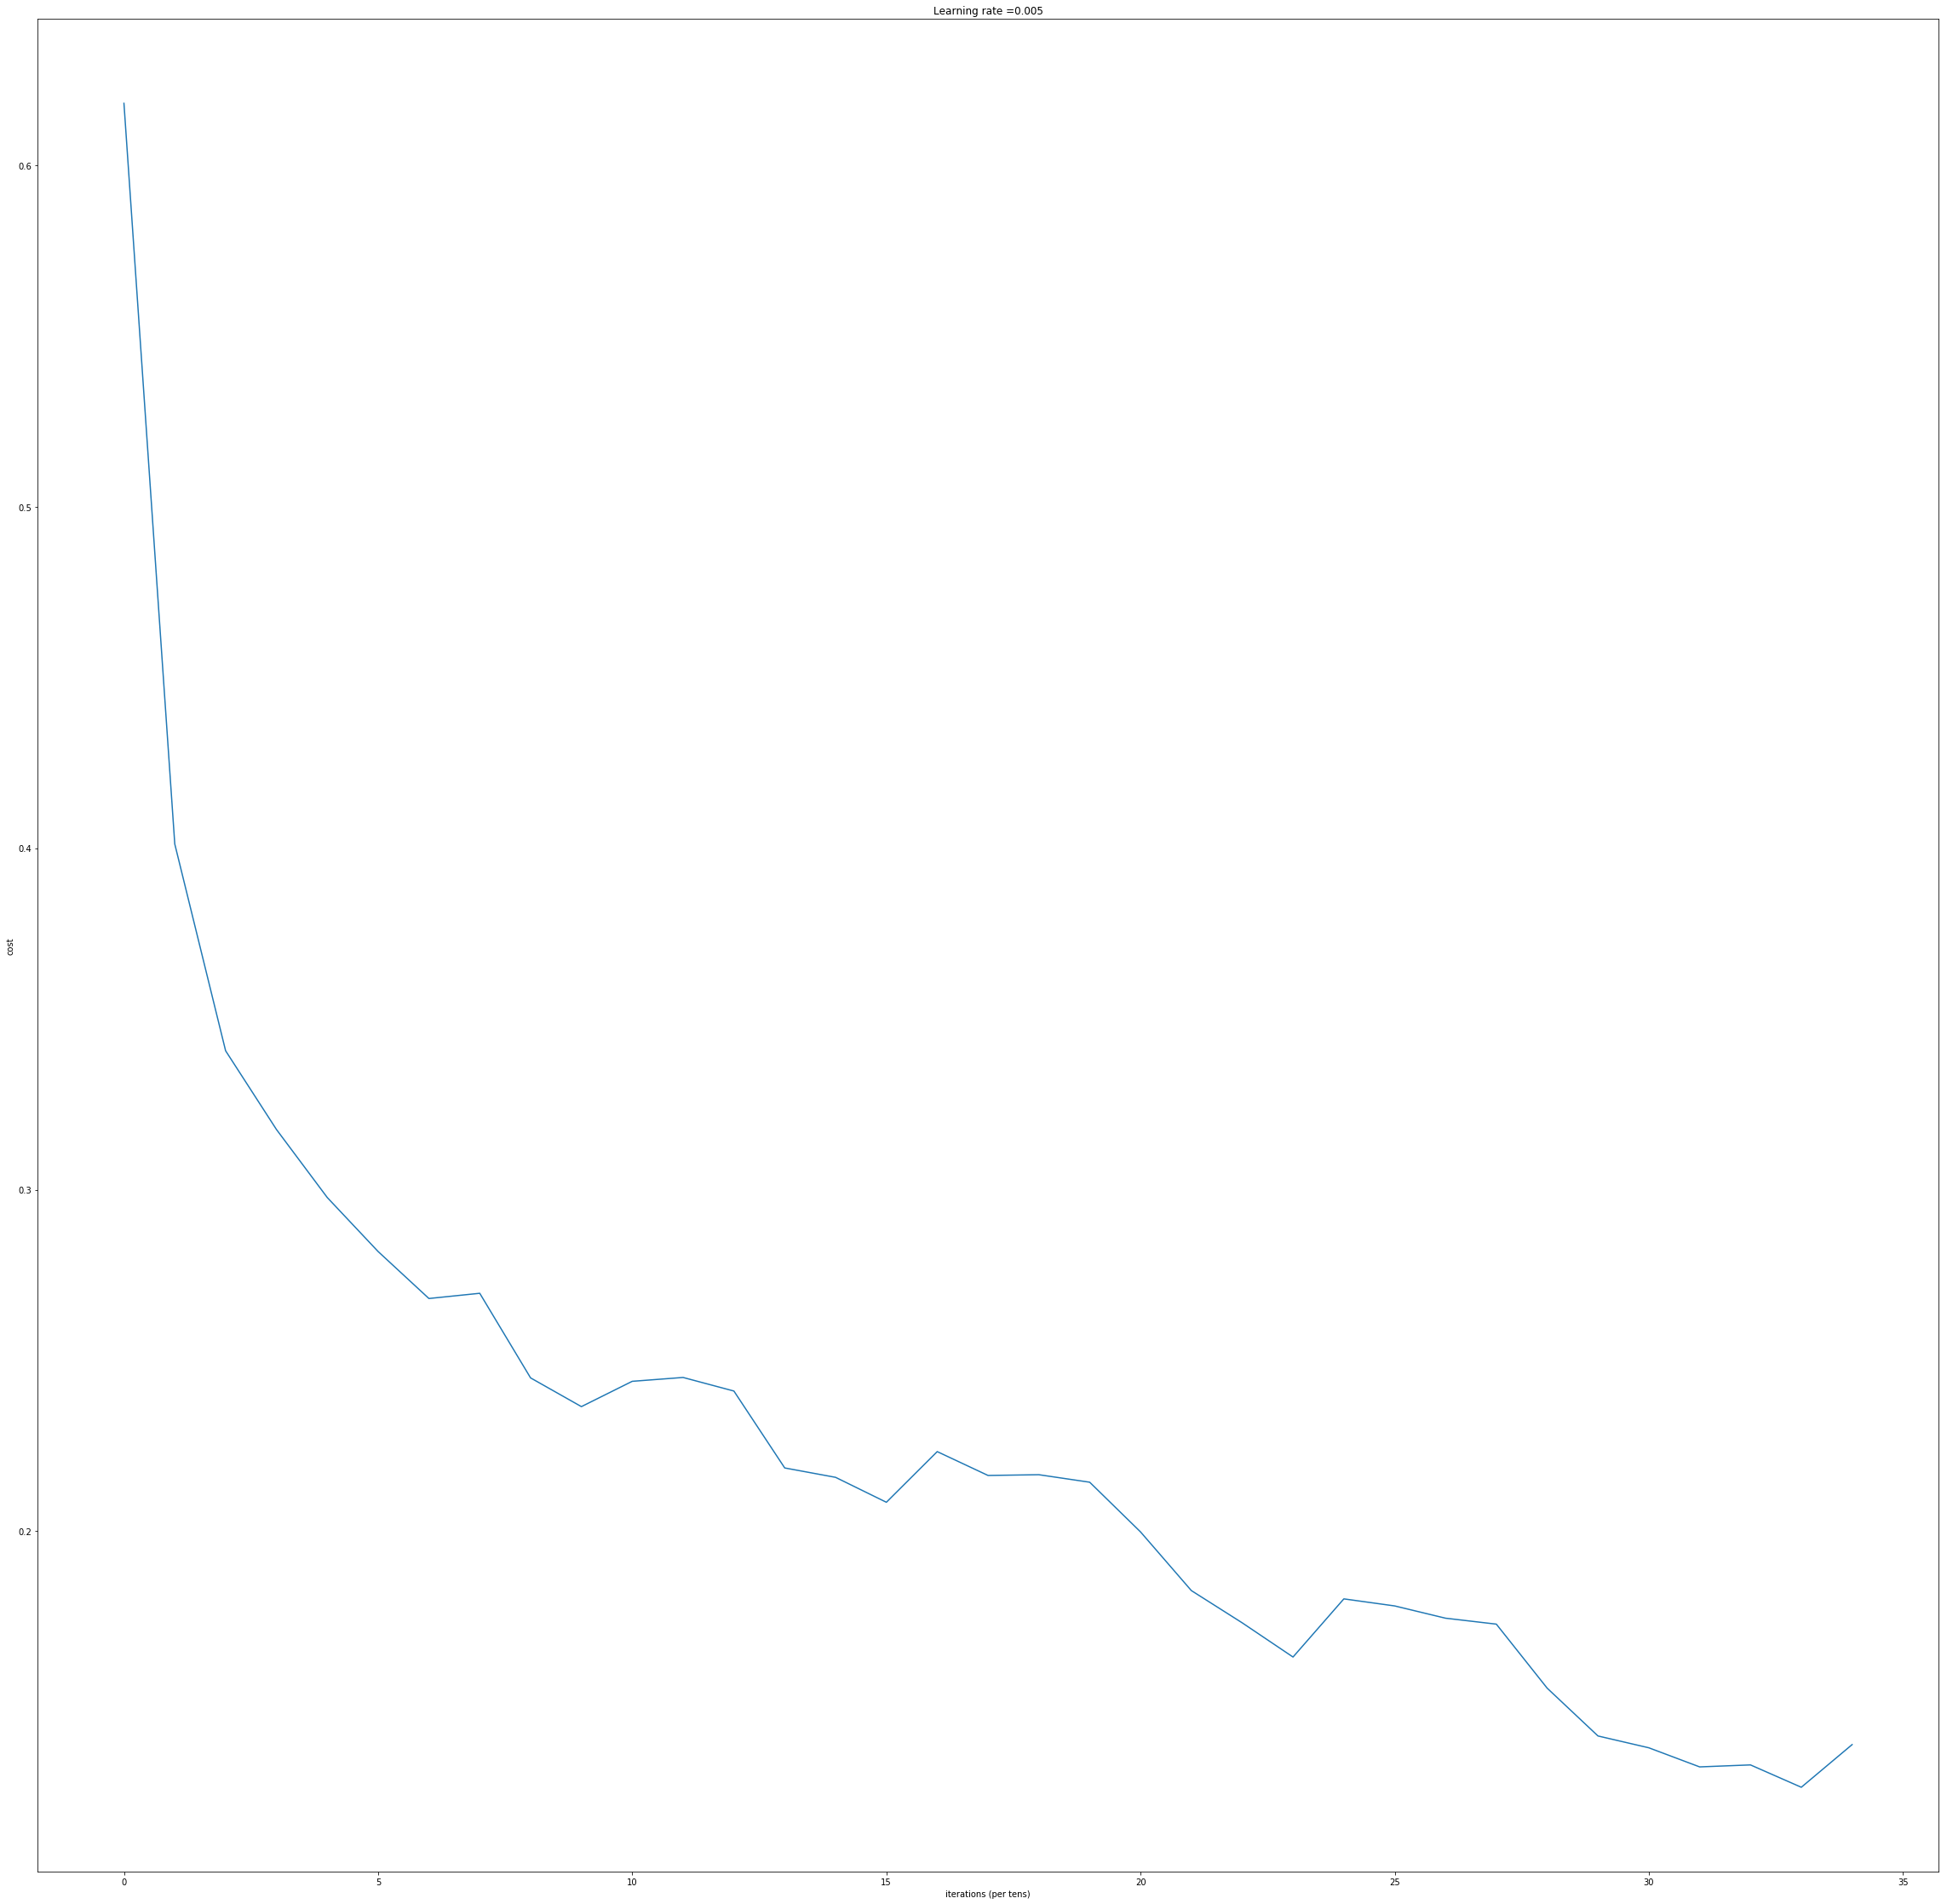

In [73]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.005, num_iterations = 3500, print_cost = True)

In [74]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9790476190476194


In [75]:
pred_dev = predict(dev_x, dev_y, parameters)

Accuracy: 0.94


In [148]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9308641975308642


### 5000 Iteraciones (learning rate 0.005)

Cost after iteration 0: 0.618120
Cost after iteration 100: 0.494350
Cost after iteration 200: 0.441283
Cost after iteration 300: 0.411454
Cost after iteration 400: 0.391254
Cost after iteration 500: 0.376044
Cost after iteration 600: 0.363423
Cost after iteration 700: 0.352706
Cost after iteration 800: 0.343460
Cost after iteration 900: 0.335390
Cost after iteration 1000: 0.328005
Cost after iteration 1100: 0.319578
Cost after iteration 1200: 0.312820
Cost after iteration 1300: 0.306863
Cost after iteration 1400: 0.301618
Cost after iteration 1500: 0.296787
Cost after iteration 1600: 0.291780
Cost after iteration 1700: 0.287344
Cost after iteration 1800: 0.283275
Cost after iteration 1900: 0.279475
Cost after iteration 2000: 0.275886
Cost after iteration 2100: 0.272496
Cost after iteration 2200: 0.269320
Cost after iteration 2300: 0.266282
Cost after iteration 2400: 0.263380
Cost after iteration 2500: 0.260609
Cost after iteration 2600: 0.257957
Cost after iteration 2700: 0.255407
Cost

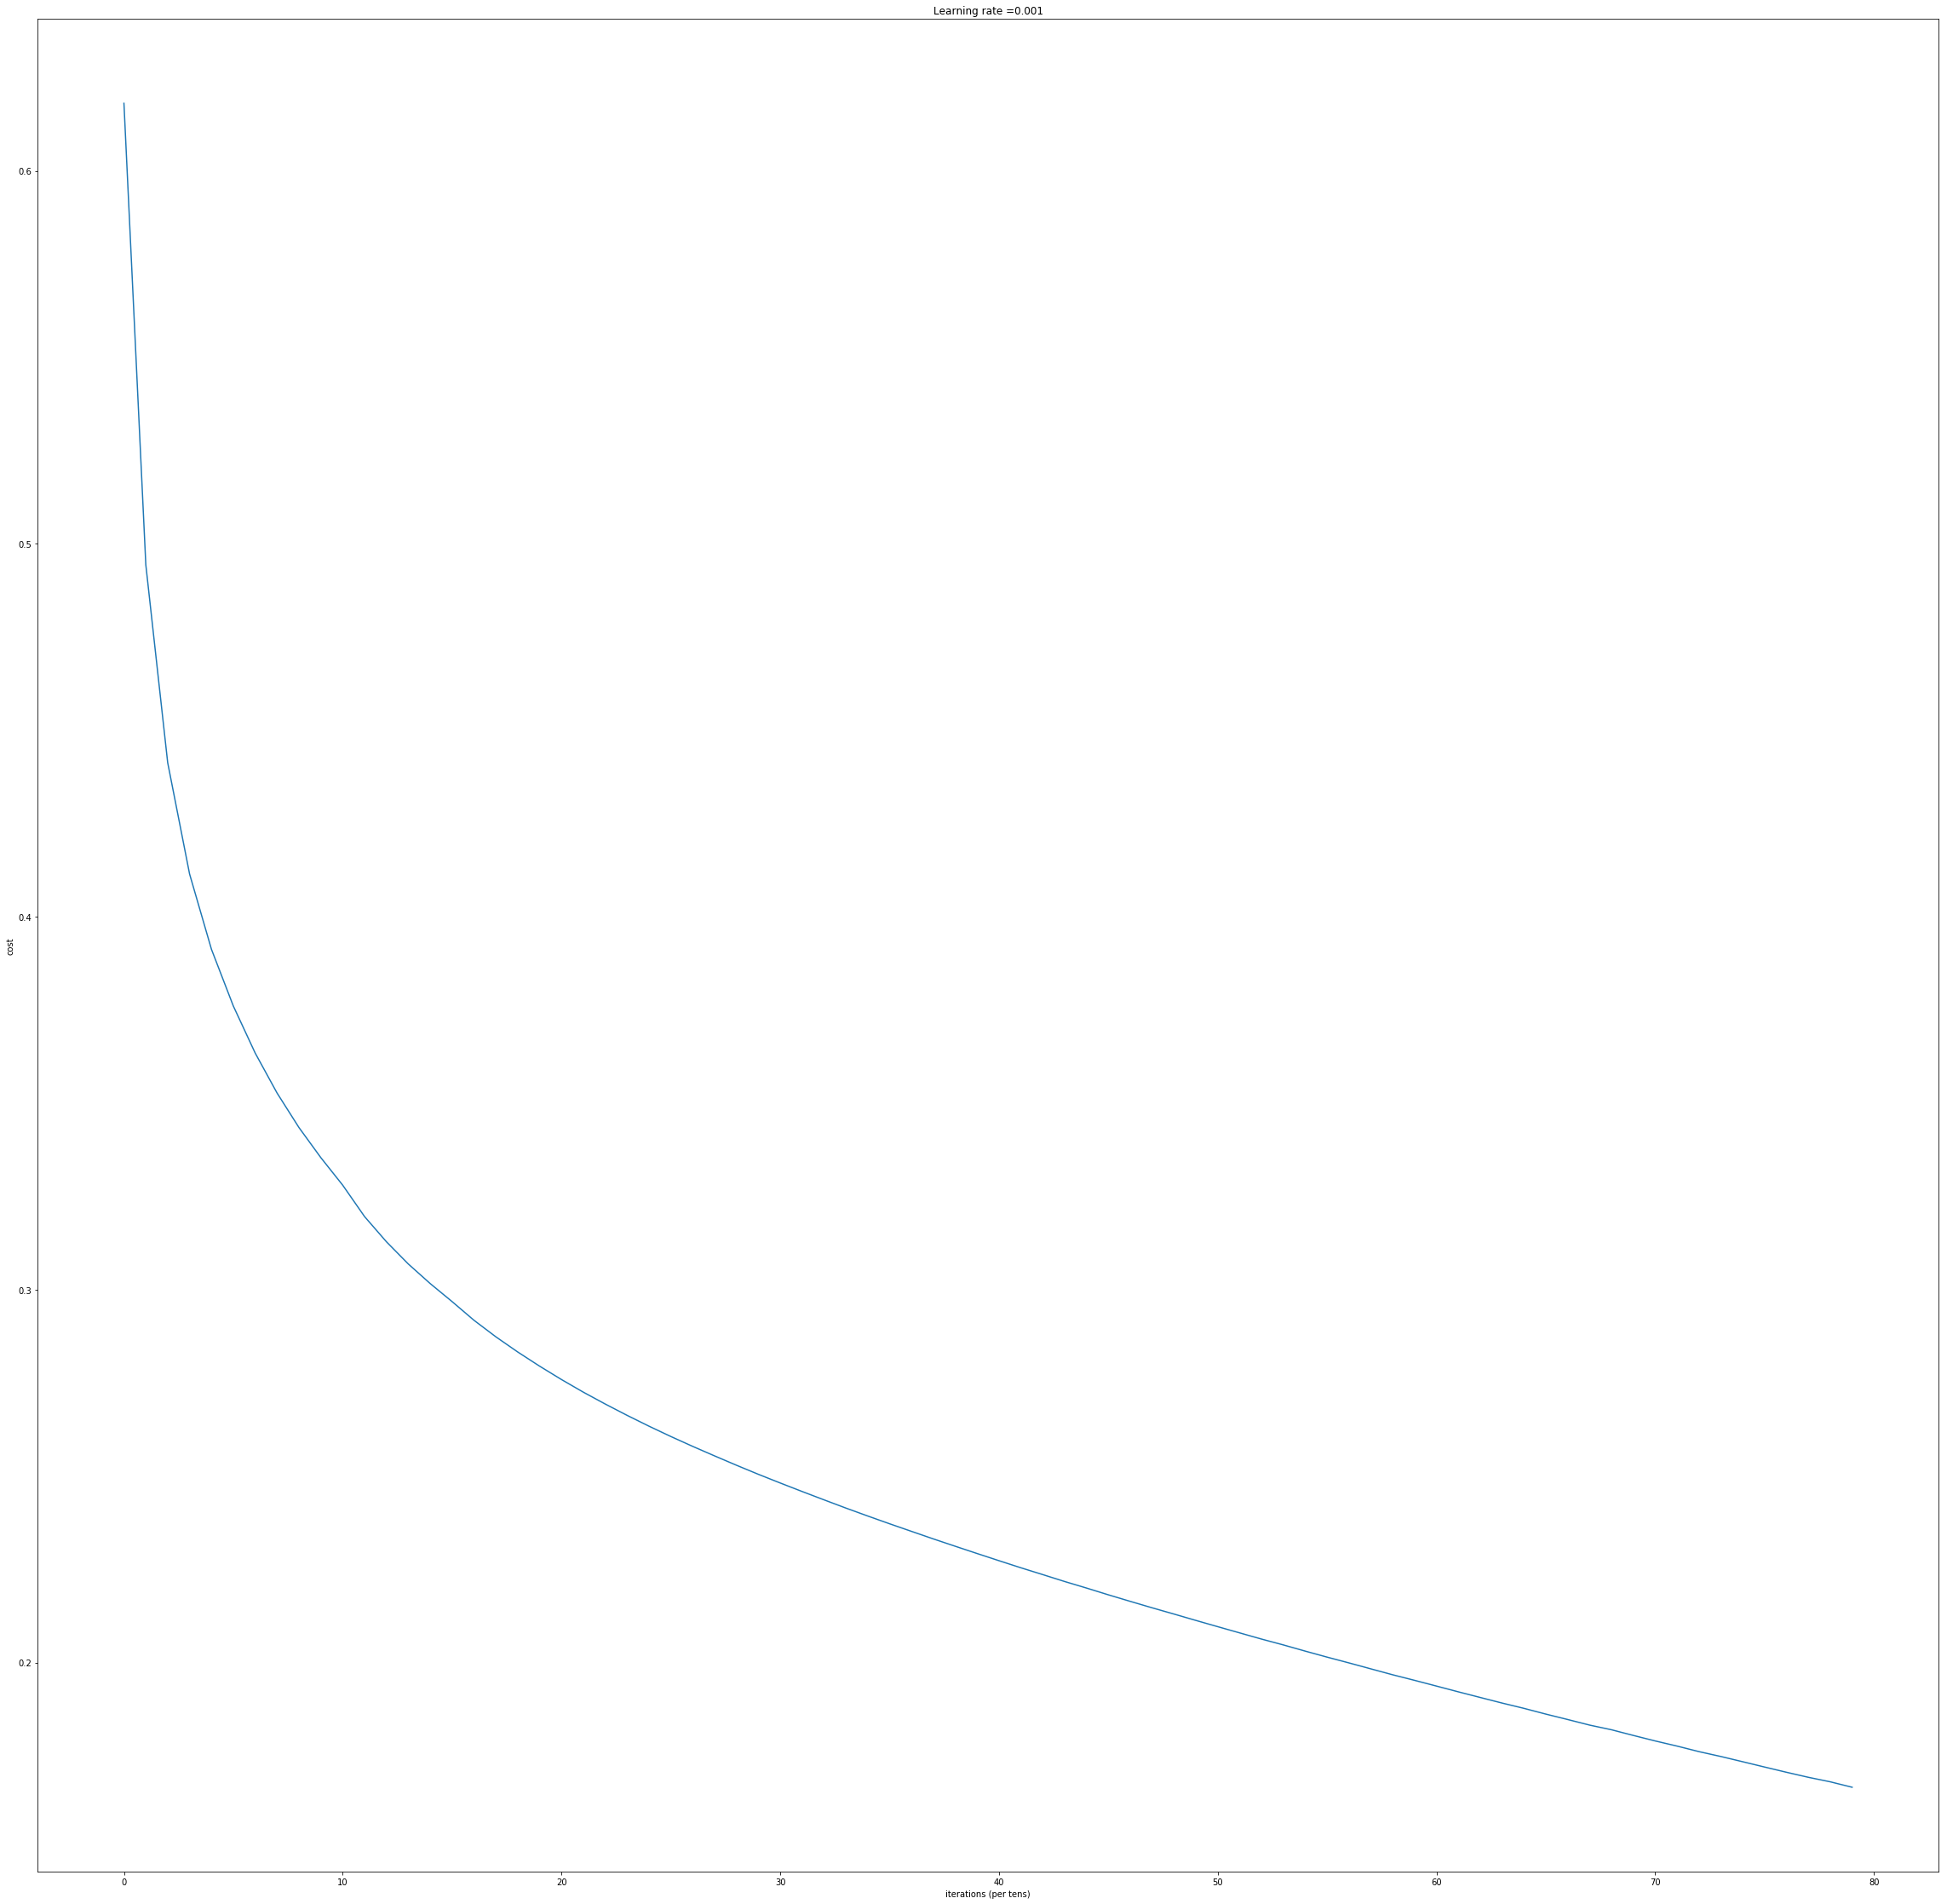

In [77]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.0025, num_iterations = 8000, print_cost = True)

In [115]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9333333333333331


In [114]:
pred_dev = predict(dev_x, dev_y, parameters)

Accuracy: 0.9


In [142]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9200000000000003
